# Introduction

#### The following notebook is inspired by the notebook [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework), which is a guide to using FastAI and Pytorch library to work on a tabular data like [Titanic dataset](https://www.kaggle.com/competitions/titanic/data). FastAI library makes training neural networks faster and easier with state-of-the-art techniques and minimal code.

#### I've gone through the above notebook and tried to implement some concepts for the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) dataset which involves predicting behavior to retain the customers, that is predicting if the customer churned based on the details

# Importing necessary libraries

#### We'll start with importing basic libraries, getting path to the dataset, changing default float display format and configuring NumPy, PyTorch and Pandas to display more data for easier readability

In [1]:
from pathlib import Path
import os

path = Path('../input/telco-customer-churn')
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00:00:0100:01


In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [3]:
import numpy as np

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [4]:
!ls {path}

WA_Fn-UseC_-Telco-Customer-Churn.csv


# Preparing the DataFrame

#### We'll read the csv file from the path above to prepare the dataframe, which be later be split into training, validation and test sets

In [5]:
full_df = pd.read_csv(path/'WA_Fn-UseC_-Telco-Customer-Churn.csv')
full_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### We'll set 12 rows aside for the test set in the beginning itself to make sure the model makes its final predictions on entirely new data which was not part of the training process.

In [6]:
df = full_df.iloc[:-12].copy()
test_df = full_df.iloc[-12:].copy()

In [7]:
len(df), len(test_df)

(7031, 12)

# Feature Engineering / Preprocessing

#### The dataset doesn't contain any null values

In [8]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### With the below quick summary of numeric columns, we want to check if any field contains really big values outside the range, in which case the large values will dominate the result and can cause problems to our model.

In [9]:
df.describe(include=(np.number))

,SeniorCitizen,tenure,MonthlyCharges
count,7031.00,7031.00,7031.00
mean,0.16,32.36,64.75
std,0.37,24.55,30.10
min,0.00,0.00,18.25
25%,0.00,9.00,35.50
50%,0.00,29.00,70.35
75%,0.00,55.00,89.85
max,1.00,72.00,118.75


#### From the above summary, it seems none of the numerical columns contain exceptionally big values. We can also plot a histogram to visually represent range of values for a given feature

<Axes: >

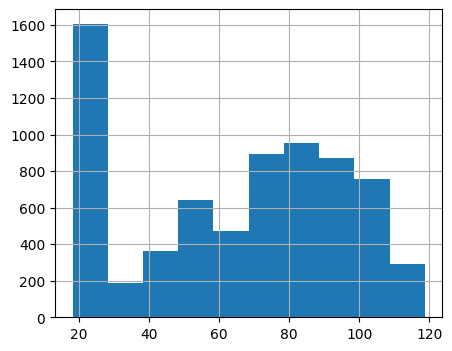

In [10]:
plt.figure(figsize=(5,4))
df['MonthlyCharges'].hist()

In [11]:
df.SeniorCitizen.unique()

array([0, 1])

#### From a quick summary of non-numeric columns below, it looks like each row of the dataset contains a unique value of customerID, so we may not consider this field while training the model.

#### Whereas, other non-numeric fields (containing 2-3 categories) like gender, Partner, Dependents, PhoneService need to be converted to integer categories since string values cannot be multiplied with coefficients

#### Also, if we take a look at TotalCharges, it looks like it contains float values represented as string within the dataset, thus we can convert this to a numeric column, then it will be easier for us to handle any null values

In [12]:
df.describe(include=[object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031,7031
unique,7031,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6519,2
top,0871-OPBXW,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3548,3634,4924,6351,3386,3089,3492,3081,3089,3465,2805,2778,3869,4161,2362,11,5165


In [13]:
for col in df.select_dtypes(include=[object]).columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print('--' * 20)

Column: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '9281-CEDRU' '2235-DWLJU' '0871-OPBXW']
----------------------------------------
Column: gender
['Female' 'Male']
----------------------------------------
Column: Partner
['Yes' 'No']
----------------------------------------
Column: Dependents
['No' 'Yes']
----------------------------------------
Column: PhoneService
['No' 'Yes']
----------------------------------------
Column: MultipleLines
['No phone service' 'No' 'Yes']
----------------------------------------
Column: InternetService
['DSL' 'Fiber optic' 'No']
----------------------------------------
Column: OnlineSecurity
['No' 'Yes' 'No internet service']
----------------------------------------
Column: OnlineBackup
['Yes' 'No' 'No internet service']
----------------------------------------
Column: DeviceProtection
['No' 'Yes' 'No internet service']
----------------------------------------
Column: TechSupport
['No' 'Yes' 'No internet service']
-------------------------

In [14]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df.describe(include=(np.number)))

       SeniorCitizen  tenure  MonthlyCharges  TotalCharges
count        7031.00 7031.00         7031.00       7020.00
mean            0.16   32.36           64.75       2282.44
std             0.37   24.55           30.10       2266.03
min             0.00    0.00           18.25         18.80
25%             0.00    9.00           35.50        401.45
50%             0.00   29.00           70.35       1396.58
75%             0.00   55.00           89.85       3794.74
max             1.00   72.00          118.75       8684.80


#### Below null values in TotalCharges will be handled by FastAI while creating dataloaders

In [15]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


<Axes: >

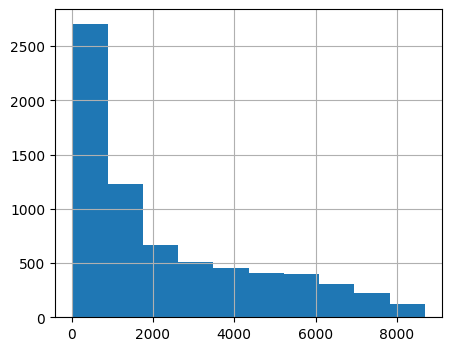

In [16]:
plt.figure(figsize=(5,4))

df['TotalCharges'].hist()

#### Splitting the dataframe into training and validation sets. Note: test set is created separately and is not a part of this 

In [17]:
splits = RandomSplitter(seed=42)(df)

# Processing Step with DataLoaders

#### Selecting the categorical columns which we want to categorize

In [18]:
columns_to_categorize=["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", 
              "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
              "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", 
              "PaymentMethod"]

#### While creating dataloaders below, we've specified the preprocessing steps to be performed that include- handling categorical features, filling missing values with the column's median and normalizing continuous features

In [19]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=columns_to_categorize,
    cont_names=["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"],
    y_names="Churn", y_block = CategoryBlock()
).dataloaders(path=".")

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


#### The neural network will contain two hidden layers, each containing 10 neurons

In [20]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

#### To find the optimal value of learning rate, we can plot the graph below, which plots Learning Rate against Loss and visually represents the values of Slide and Valley, we'll pick the loss value which lies between the two

SuggestedLRs(slide=0.14454397559165955, valley=0.0063095735386013985)

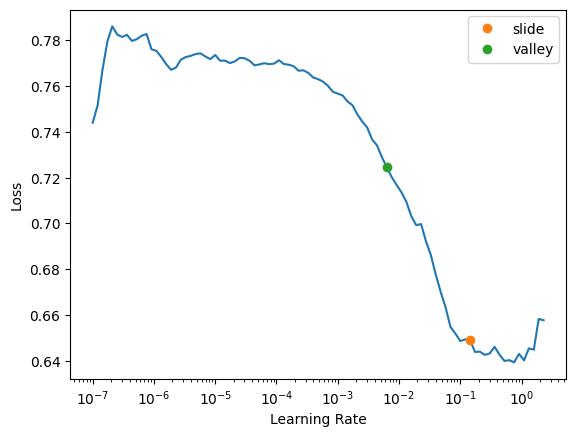

In [21]:
learn.lr_find(suggest_funcs=(slide, valley))

In [22]:
learn.fit(16, lr=0.04)

epoch,train_loss,valid_loss,accuracy,time
0,0.439639,0.438911,0.765292,00:01
1,0.435610,0.432210,0.790185,00:00
2,0.431693,0.395080,0.815078,00:00
3,0.430546,0.413533,0.798720,00:00
4,0.429990,0.392638,0.810811,00:00
5,0.436893,0.395330,0.819346,00:00
6,0.439864,0.395948,0.813656,00:00
7,0.422917,0.389543,0.816501,00:00
8,0.431432,0.397933,0.812945,00:00
9,0.440730,0.400265,0.817923,00:00


#### After training the model for 16 iterations, we get an accuracy of 0.801 (~0.80). We can experiment with different values of hyperparameters and additional preprocessing steps to check if it results in improved accuracy. However, for now, we'll proceed with this model and evaluate the test set results.

# Test Set

#### Carrying out the same preprocessing step we did earlier which includes- converting TotalCharges to a numeric column

In [23]:
test_df['TotalCharges'] = pd.to_numeric(test_df['TotalCharges'], errors='coerce')

#### Checking if this column contains any null values in the test set

In [24]:
test_df[test_df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


#### Since we do not want to repeat the processing steps like categorify, fill missing, we can simply retrieve the saved learner

In [25]:
tst_dl = learn.dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


# Getting Test set predictions

#### The predictions are in the form of a 2D tensor, from which we retrive index of the maximum value and map them to their corresponding class labels using dataloader's vocabulary

In [26]:
preds,_ = learn.get_preds(dl=tst_dl)

In [27]:
preds

tensor([[0.9450, 0.0550],
        [0.3433, 0.6567],
        [0.7699, 0.2301],
        [0.8845, 0.1155],
        [0.6016, 0.3984],
        [0.8809, 0.1191],
        [0.9773, 0.0227],
        [0.9504, 0.0496],
        [0.9134, 0.0866],
        [0.6364, 0.3636],
        [0.4556, 0.5444],
        [0.9448, 0.0552]])

In [28]:
pred_index = preds.argmax(dim=1)
pred_index

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [29]:
pred_label = [learn.dls.vocab[i] for i in pred_index]
pred_label

['No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']

In [30]:
[i for i in test_df['Churn']]

['No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']

#### Comparing the Customer Churn actual values and predictions of the test set, we can tell 11 out of 12 predictions are correct

# Ensembling

#### In this ensembling approach, we train four separate models, each initialized with a different random seed. We then combine their predictions by averaging them, and finally evaluate the ensemble's performance on the test set to compare it with the previous method.

In [31]:
def ensemble_func():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])
    with learn.no_bar(), learn.no_logging(): 
        learn.fit(16, lr=0.04)
    e_pred = learn.get_preds(dl=tst_dl)
    return e_pred[0]

In [32]:
learns = [ensemble_func() for i in range(4)]

In [33]:
en_pred = torch.stack(learns).mean(0)

In [34]:
en_pred

tensor([[0.9629, 0.0371],
        [0.1516, 0.8484],
        [0.7328, 0.2672],
        [0.8177, 0.1823],
        [0.4935, 0.5065],
        [0.8589, 0.1411],
        [0.9837, 0.0163],
        [0.9287, 0.0713],
        [0.7800, 0.2200],
        [0.6172, 0.3828],
        [0.2265, 0.7735],
        [0.9173, 0.0827]])

In [35]:
en_index = en_pred.argmax(dim=1)
en_index

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [36]:
en_label = [learn.dls.vocab[i] for i in en_index]
en_label

['No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']

In [37]:
[i for i in test_df['Churn']]

['No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']

#### From the above test set predictions using ensembling approach, we notice that 10 out of 12 predictions are correct. This performance is almost similar to what we achieved in the previous approach